In [2]:
import joblib
import shap
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')

import load_balanced
import torch
import pandas as pd
import torch.nn as nn


C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
modelfile = '../models/model_DNN_1_50000_128_RELU_final_.pkl'

In [4]:
model=joblib.load(modelfile)

In [5]:
# ca ne marche pas si la dimension de sortie n'est pas donnees x 5

In [6]:
new_model = nn.Sequential(
    model,
    nn.Softmax(dim=-1),
    nn.Flatten(start_dim=1)
)


In [7]:
new_model.eval()

Sequential(
  (0): Sequential(
    (0): Linear(in_features=187, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=5, bias=True)
  )
  (1): Softmax(dim=-1)
  (2): Flatten(start_dim=1, end_dim=-1)
)

# data

je ne sais pas si ce shap a besoin des données entrainées réellement avec le modèle ou pas

##### full train dataset

In [14]:
X_train,y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_50000.csv')
X =  np.expand_dims(X_train,axis=1)
X = torch.from_numpy(X).float()

#### small train dataset

In [9]:
X_train,y_train = load_balanced.load('../data/raw/mitbih_train.csv')
ii_3 = np.array([k for k,x in enumerate(y_train) if x == 3])
n3 = ii_3.shape[0]
X = X_train[ii_3,:]
y = y_train[ii_3]
for cl in [0,1,2,4]:
    ii = np.array([k for k,x in enumerate(y_train) if x == cl])
    np.random.shuffle(ii)
    ii = ii[:n3]
    X = np.concatenate((X,X_train[ii,:]))
    y = np.concatenate((y,y_train[ii]))

ii = np.arange(X.shape[0])
X = X[ii,:]  
y = y[ii]

In [10]:
pd.Series(y).value_counts()

3.0    641
0.0    641
1.0    641
2.0    641
4.0    641
Name: count, dtype: int64

In [11]:
X =  np.expand_dims(X,axis=1)
X = torch.from_numpy(X).float()

In [12]:
X_test,y_test = load_balanced.load('../data/raw/mitbih_test.csv')
ii = np.arange(X_test.shape[0])
np.random.shuffle(ii)

X_test = X_test[ii,:]
y_test = y_test[ii]


In [13]:

X_test =  np.expand_dims(X_test,axis=1)
X_test = torch.from_numpy(X_test).float()

In [14]:
print(X_test.shape)
print(X.shape)


torch.Size([21892, 1, 187])
torch.Size([3205, 1, 187])


## SHAP

In [15]:
explainer  = shap.DeepExplainer(new_model, X)


In [61]:
def visualize_single(explainer,ii,X_test,y_test):

    shap_values = explainer.shap_values(X_test[ii,:,:].unsqueeze(0))
    pred = torch.argmax(model(X_test[ii,:,:].unsqueeze(0))).detach().numpy()
    
    fig = plt.figure(figsize=(15,10))
    for k in range(5):
        ax = fig.add_subplot(511+k)
        ax.plot(X_test[ii,0,:])
        im = ax.imshow(shap_values[0,:,:,k],aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
        im.set_clim([-abs(shap_values).max(),abs(shap_values).max()])
        ax.set_title('shap values class {k}, pred {pred},true {true}'.format(k=k,pred=pred,true=y_test[ii]))
    fig.tight_layout()

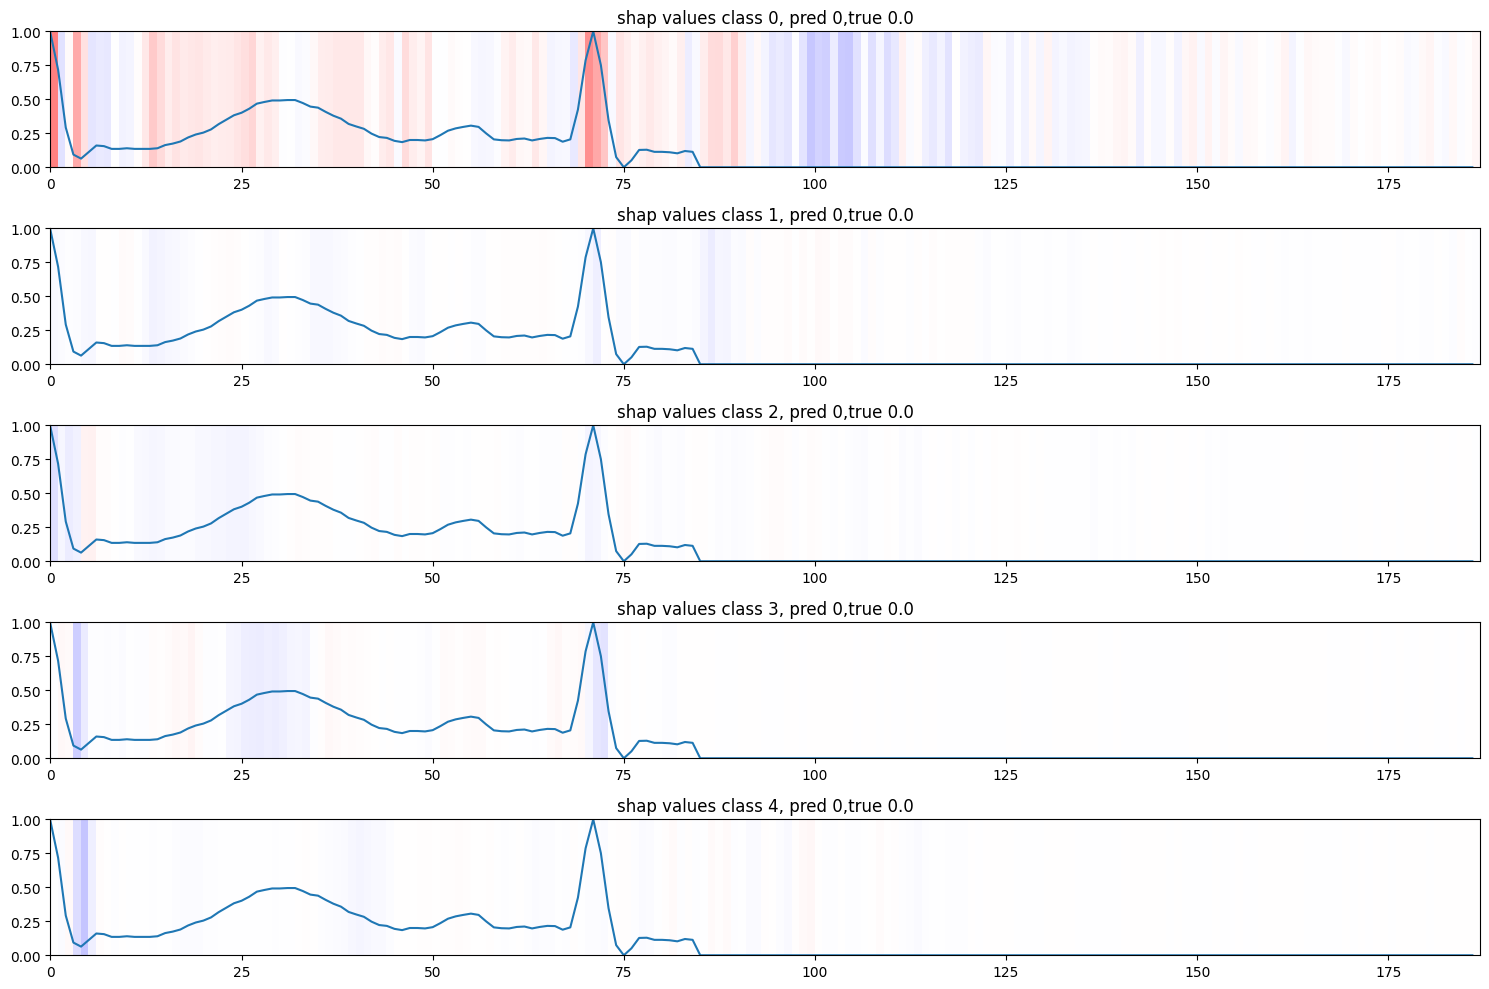

In [62]:
visualize_single(explainer,68,X_test,y_test)

In [65]:
jj = np.random.randint(X_test.shape[0])

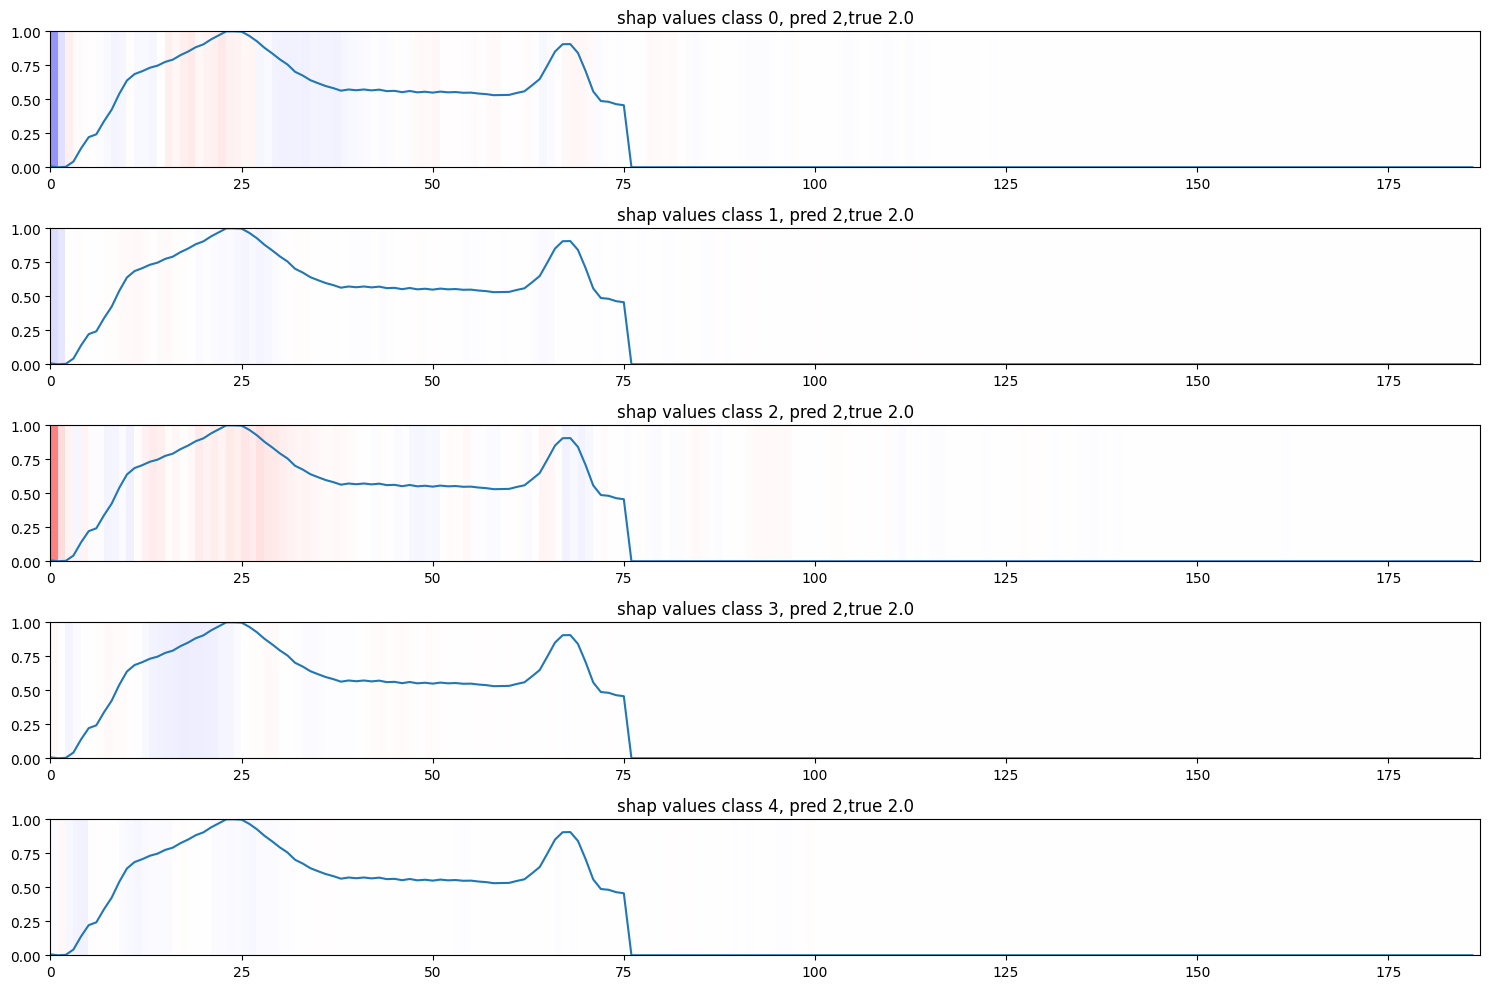

In [67]:
visualize_single(explainer,jj,X_test,y_test)

In [81]:
kk = []

for k in range(5):
    v = np.array([a for a,b in  enumerate(y_test) if k==b])
    kk += [v[ii] for ii in np.random.randint(v.shape[0],size=(10,))]

In [83]:
all = explainer.shap_values(X_test[np.array(kk),:,:])

In [89]:
pred = y_test[np.array(kk)].astype(int)

In [103]:
shaps = explainer(X_test[np.array(kk),:,:])

In [104]:
shaps.values.shape

(50, 1, 187, 5)

In [ ]:
# explications pour la classe 0

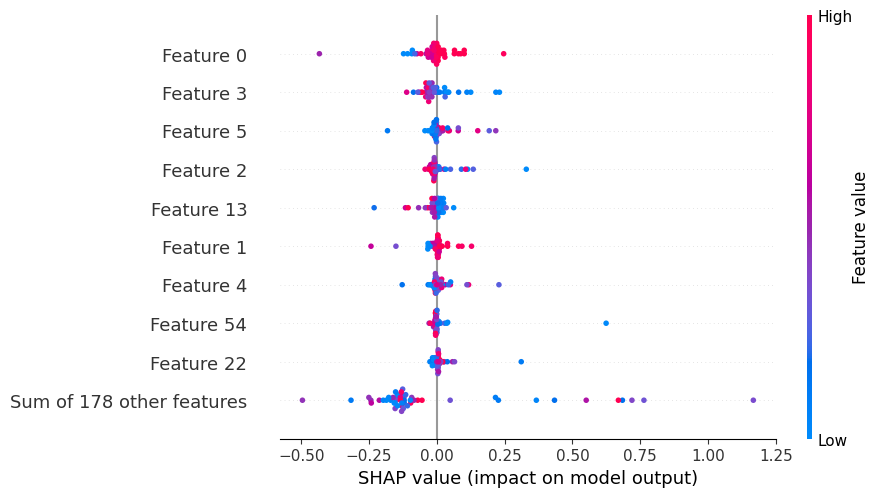

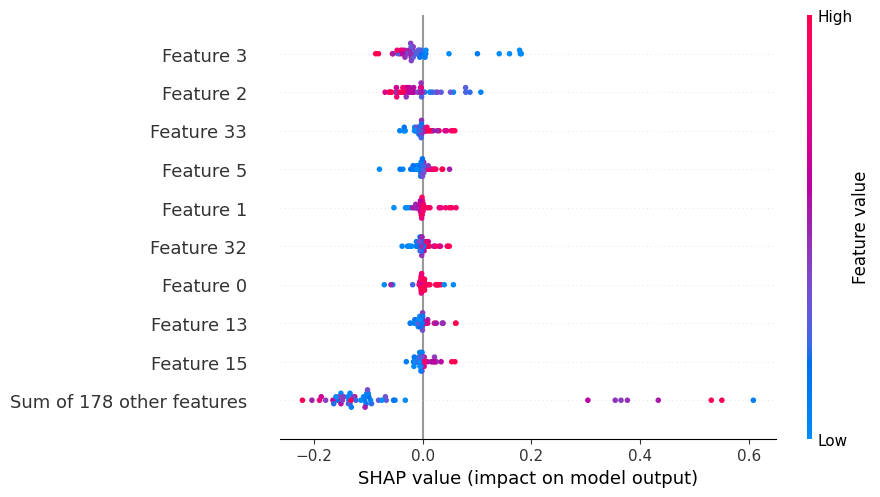

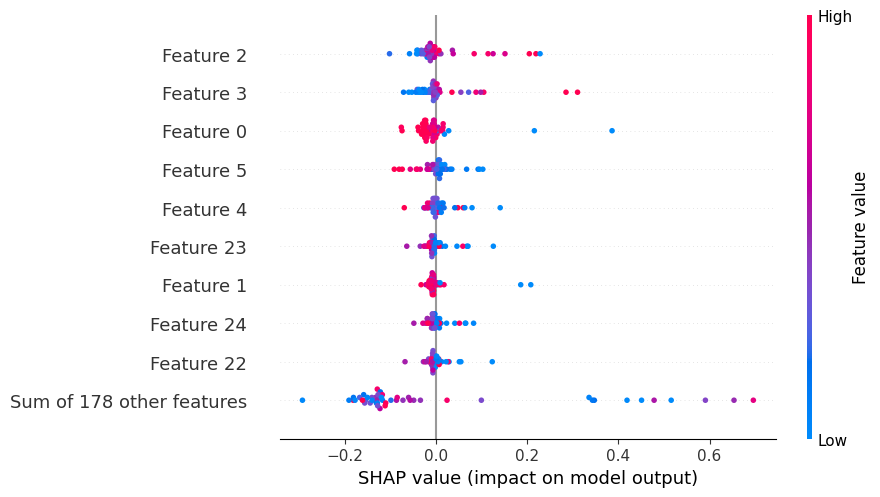

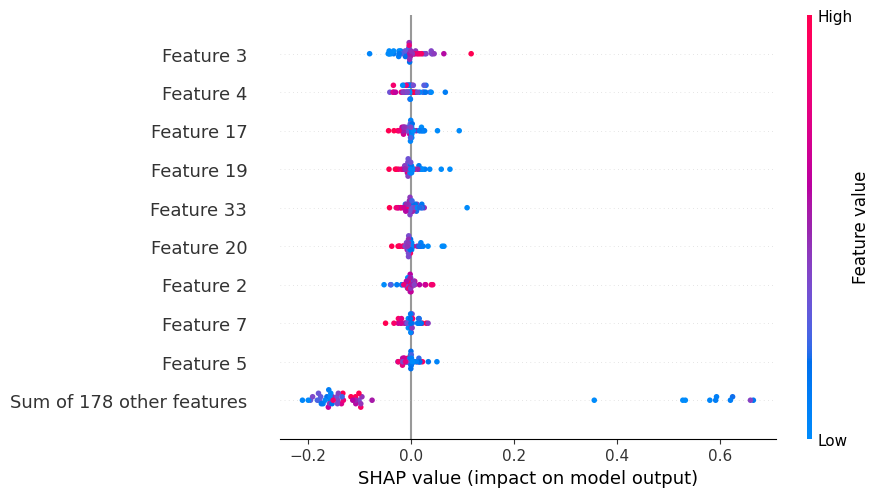

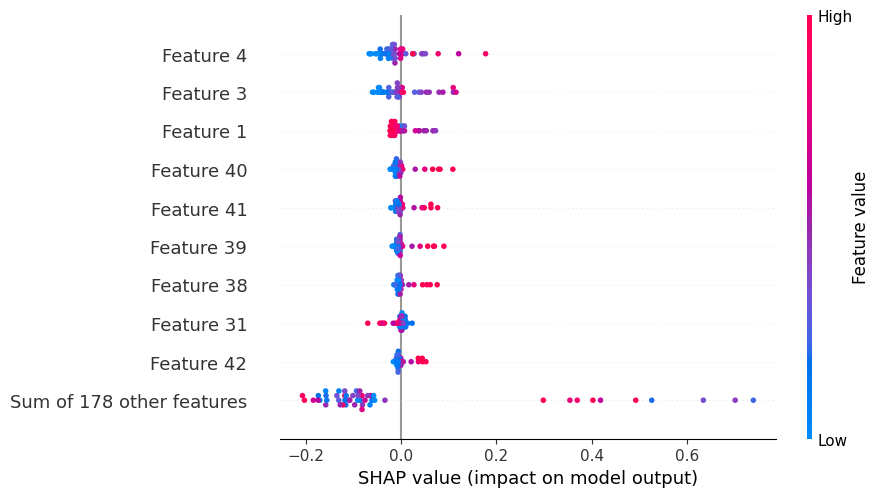

In [107]:
for k in range(5):
    shap.plots.beeswarm(shaps[:,0,:,k])